# Surface Defect Detection

In this notebook, we are going to create a convolutional neural network that can detect surface defects.
Previously we have used Torch but now PyTorch will be used.

PyTorch is the freshest flavour of the Torch. It combines customization of Torch with Python ease of use. It completely covers the Torch functionality, on top of that, new Autograd mechanism, dataset loaders and lots of utilities have been added for convenience.

First, let's import required packages...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import PIL
%matplotlib inline
plt.ion()

In [2]:
# Flower set mean and std values
# mean : 0.395643072401
# std : 0.261506619928

PyTorch lets us define a set of transformations to the loaded datasets. 

First images are converted to Torch tensors and then we will be scaling the images to 64 pixels in the smaller dimension. 

In [3]:
dataTransforms = {
    'train': transforms.Compose([
        transforms.Scale(64), # May have to change to transforms.Scale(64) because of a bug in scale function
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Scale(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

Unlike Torch, PyTorch now supports direct image folder loading as the data. This completely removes the big dataset preparation step.

Additionally new dataset loaders allow setting batch size, shuffle and several other useful parameters.

Lastly checking the CUDA support is now easier with `torch.cuda.is_available()`

In [4]:
baseDirectory = 'f:/Datasets/'
#setDirectory = 'hymenoptera_data'
setDirectory = 'flower_photos'
setImageSize = 64
setPath = os.path.join(baseDirectory, setDirectory)
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(setPath, x), dataTransforms[x])
           for x in ['train', 'test']}
datasetLoaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4)
                for x in ['train', 'test']}
testLoader = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=4)
datasetSizes = {x: len(datasets[x]) for x in ['train', 'test']}
datasetClasses = datasets['train'].classes

useGPU = torch.cuda.is_available()
print(str(datasetSizes) + ' images will be used' )
print('GPU will ' + ('' if useGPU else 'not ') + 'be used' )

{'train': 1331, 'test': 200} images will be used
GPU will be used


Here we define the simple image displaying function and use the new dataset iterator to get one random sample to display it.

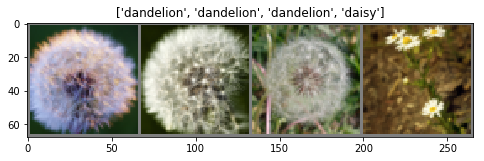

In [5]:
def ImShow(input, title=None):
    plt.figure(figsize=(8,8))

    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(datasetLoaders['train']))
out = torchvision.utils.make_grid(inputs)
ImShow(out, title=[datasetClasses[x] for x in classes])

## Training the model
Here we have 2 different training functions. First one uses mini batches and a separate learning-rate scheduler function for training.

Second one is the Torch style training which uses all of the images in the training set for each training iteration.

In [6]:
def TrainModelMiniBatch(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in datasetLoaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if useGPU:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects / datasetSizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [7]:
def TrainModelBatch(model, criterion, optimizer, lrDecay, maxIteration):
    currentIteration = 0
    startTime = time.time()
    trainSetSize = datasetSizes['train']
    
    shuffledIndices = torch.randperm(trainSetSize)
    print('Started training...')
    
    while True:
        runningLoss = 0
        for iInput, data in enumerate(datasetLoaders['train'], 0):
            inputs, labels = data
            if useGPU:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print(iInput)
            runningLoss += loss.data[0]
            
        currentError = runningLoss / trainSetSize
        print('Iteration: ' + str(currentIteration) + '# current error = ' + str(currentError))
        currentIteration += 1
        
        if maxIteration > 0 and currentIteration > maxIteration:
            print('# Maximum iteration reached. End of training.')
            print('# Training error = ' + str(currentError))
            timeElapsed = time.time() - startTime            
            print('Training complete in {:.0f}m {:.0f}s'.format(timeElapsed // 60, timeElapsed % 60))
            break


Time to write the learning rate changer function.

In [8]:
def ExpLRScheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    return optimizer

Function to visualize predictions

In [9]:
def VisualizeModel(model, numImages=6):
    imagesSoFar = 0
    fig = plt.figure()
    plt.figure(figsize=(16, 16))
    
    for i, data in enumerate(datasetLoaders['test']):
        inputs, labels = data
        if useGPU:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            imagesSoFar += 1
            ax = plt.subplot(numImages // 2, 2, imagesSoFar)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(datasetClasses[labels.data[j]]))
            ImShow(inputs.cpu().data[j])
            
            if imagesSoFar == numImages:
                return

def VisualizeLayer(layer):
    fig = plt.figure()
    imagesSoFar = 0
    plt.figure(figsize=(16,16))
    
    for i in range(layer.size()[2]):
        for j in range(layer.size()[3]):
            imagesSoFar += 1
            ax = plt.subplot(layer.size()[0] // 2, 2, imagesSoFar)
            ax.axis('off')
            input = layer.data.numpy()[:,:,i,j]
            #input = input.numpy().transpose((1, 2, 0))
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            #input = std * input + mean
            #plt.figure(figsize=(1,1))
            plt.imshow(input)


Now it is time to define the neural network.

In [12]:
#outMul = setImageSize / 8

#model = nn.Sequential(
#    nn.Conv2d(1, 32, (3,3), (1,1), (1,1)),
#    nn.ReLU(),
#    nn.MaxPool2d(2, 2),
#    nn.Conv2d(32, 32, (3,3), (1,1), (1,1)),
#    nn.ReLU(),
#    nn.MaxPool2d(2, 2),
#    nn.Conv2d(32, 32, (3,3), (1,1), (1,1)),
#    nn.ReLU(),
#    nn.MaxPool2d(2, 2),
#)


# Currently, weights are not shared.
# TODO: Try weight sharing with looping the element
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3), (1,1), (1,1))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, (3,3), (1,1), (1,1))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, (3,3), (1,1), (1,1))
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # requires int casting in Python, might run into problems with other image sizes
        self.outMul = int(setImageSize / 8) 
        self.fc1 = nn.Linear(32 * self.outMul * self.outMul, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fc4 = nn.Linear(4096, 2) # number of classes
        self.logsmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = x.view(-1, 32 * self.outMul * self.outMul)
        
        x = F.dropout(F.relu(self.fc1(x)), 0.5)
        x = F.dropout(F.relu(self.fc2(x)), 0.5)
        x = F.dropout(F.relu(self.fc3(x)), 0.5)
        x = self.logsmax(self.fc4(x))
        return x

net = Net()
if useGPU:
    net = net.cuda()
        

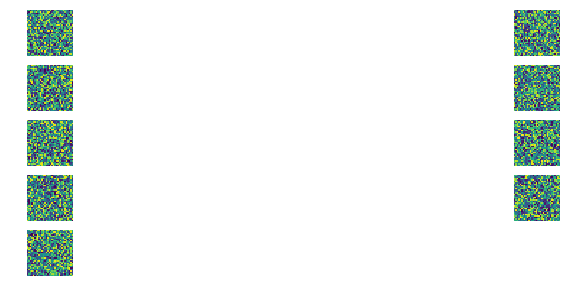

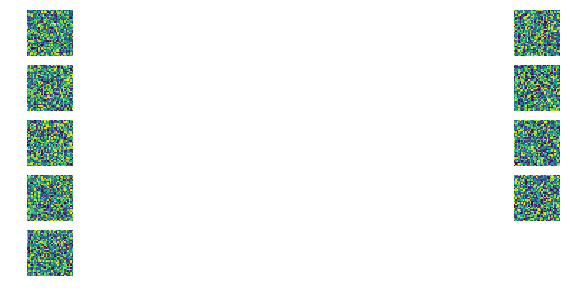

In [11]:
VisualizeLayer(net.conv2.cpu().weight)
VisualizeLayer(net.conv3.cpu().weight)

We successfully created our neural network. Now it is time to define a loss function and the optimizer.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if useGPU:
    criterion = criterion.cuda()

It is time to train the network. 

`Mini-batch`: With batch size of 4, it takes 1m30s to train 10 epochs with 87.5% train and 77% test accuracy.

In [11]:
TrainModelMiniBatch(net, criterion, optimizer, ExpLRScheduler, num_epochs=10)          

Epoch 0/9
----------
LR is set to 0.001
train Loss: 0.1696 Acc: 0.5995
test Loss: 0.1753 Acc: 0.5000

Epoch 1/9
----------
train Loss: 0.1676 Acc: 0.5995
test Loss: 0.1752 Acc: 0.5000

Epoch 2/9
----------
train Loss: 0.1624 Acc: 0.6131
test Loss: 0.1693 Acc: 0.5000

Epoch 3/9
----------
train Loss: 0.1442 Acc: 0.7137
test Loss: 0.1346 Acc: 0.7400

Epoch 4/9
----------
train Loss: 0.1159 Acc: 0.7919
test Loss: 0.1301 Acc: 0.7450

Epoch 5/9
----------
train Loss: 0.0988 Acc: 0.8264
test Loss: 0.1369 Acc: 0.7500

Epoch 6/9
----------
train Loss: 0.0870 Acc: 0.8497
test Loss: 0.1335 Acc: 0.7450

Epoch 7/9
----------
LR is set to 0.0001
train Loss: 0.0747 Acc: 0.8723
test Loss: 0.1296 Acc: 0.7600

Epoch 8/9
----------
train Loss: 0.0734 Acc: 0.8760
test Loss: 0.1311 Acc: 0.7500

Epoch 9/9
----------
train Loss: 0.0730 Acc: 0.8753
test Loss: 0.1299 Acc: 0.7700

Training complete in 1m 30s
Best val Acc: 0.770000


Net (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (2048 -> 4096)
  (fc2): Linear (4096 -> 4096)
  (fc3): Linear (4096 -> 4096)
  (fc4): Linear (4096 -> 2)
  (logsmax): LogSoftmax ()
)

For batch training which uses all training images for one weight update operation, it takes 1m18s to train 10 epochs with 88.5% train and 75.5% test accuracy.

In [14]:
TrainModelBatch(net, criterion, optimizer, 0, maxIteration=10)

Started training...
Iteration: 0# current error = 0.1698717315066228
Iteration: 1# current error = 0.16763458844864843
Iteration: 2# current error = 0.16207773621865093
Iteration: 3# current error = 0.14078127620230932
Iteration: 4# current error = 0.1147226737707204
Iteration: 5# current error = 0.096933600350733
Iteration: 6# current error = 0.08755527692829461
Iteration: 7# current error = 0.08487773423554036
Iteration: 8# current error = 0.07702263085777535
Iteration: 9# current error = 0.0754823799529844
Iteration: 10# current error = 0.07073476860701344
# Maximum iteration reached. End of training.
# Training error = 0.07073476860701344
Training complete in 1m 18s


In [17]:
VisualizeModel(net)

NameError: name 'VisualizeModel' is not defined

Net (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (2048 -> 4096)
  (fc2): Linear (4096 -> 4096)
  (fc3): Linear (4096 -> 4096)
  (fc4): Linear (4096 -> 2)
  (logsmax): LogSoftmax ()
)
C1: torch.Size([32, 3, 3, 3])
C2: torch.Size([32, 32, 3, 3])
C3: torch.Size([32, 32, 3, 3])


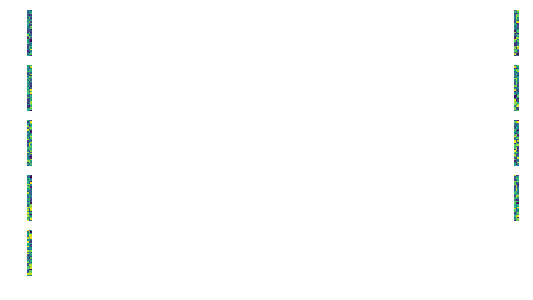

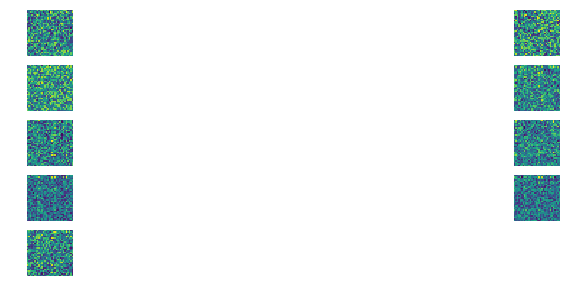

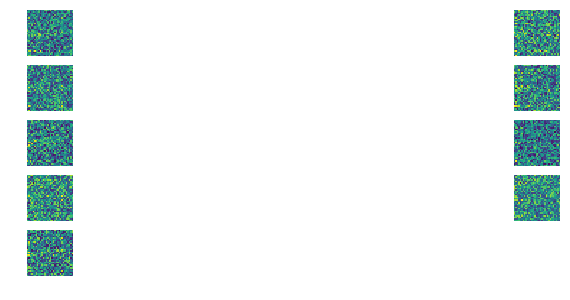

In [143]:


print(net)
print('C1: ' + str(net.conv1.cpu().weight.size()))
print('C2: ' + str(net.conv2.cpu().weight.size()))
print('C3: ' + str(net.conv3.cpu().weight.size()))
VisualizeLayer(net.conv1.cpu().weight)
VisualizeLayer(net.conv2.cpu().weight)
VisualizeLayer(net.conv3.cpu().weight)


Let's calculate the accuracy on the training set.

In [15]:
correct = 0
total = 0
for data in datasetLoaders['train']:
    # Inputs
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

print('Accuracy of the network for training set is {}%'.format(100 * correct / total))

Accuracy of the network for training set is 88.50488354620586%


Now time to see the real accuracy with the training set.

In [16]:
correct = 0
total = 0
for data in datasetLoaders['test']:
    # Inputs
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

print('Accuracy of the network for test set is {}%'.format(100 * correct / total))

Accuracy of the network for test set is 75.5%


In [19]:
classCorrect = list(0. for i in range(2))
classTotal = list(0. for i in range(2))

for i, data in enumerate(testLoader):
    inputs, labels = data
    if useGPU:
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    classTotal[labels.data.cpu().numpy()[0]] += 1
    
    if labels.data.cpu().numpy()[0] == predicted.cpu().numpy()[0][0]:
        classCorrect[labels.data.cpu().numpy()[0]] += 1

for i, cls in enumerate(classCorrect):
    print('Class ' + datasetClasses[i] + ' total: ' + str(classTotal[i]) + ' correct: ' + str(classCorrect[i]) + ' success rate is ' + str(100 * classCorrect[i] / classTotal[i])) 


Class daisy total: 100.0 correct: 62.0 success rate is 62.0
Class dandelion total: 100.0 correct: 89.0 success rate is 89.0


In [64]:
print(datasetLoaders['test'].)